# ---- EXPLORATORY DATA ANALYSIS (EDA) ----

`El objetivo fundamental de este análisis es encontrar "correlaciones efectivas" entre aquellas variables de interés para el estudio.`

### >>> Librerías

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt
import folium
from folium import plugins
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


### >>> Cargue de fuentes de datos

In [2]:
df_vh = pd.read_csv('./Datasets/ETL/victimas_hechos.csv') 

In [3]:
df_vh.shape

(717, 30)

In [4]:
df_vh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   EDAD_VICTIMA           717 non-null    object 
 1   FECHA_x                717 non-null    object 
 2   FECHA_AA               717 non-null    int64  
 3   FECHA_DD               717 non-null    int64  
 4   FECHA_DECESO           717 non-null    object 
 5   FECHA_MM               717 non-null    int64  
 6   ID                     717 non-null    object 
 7   ROL_VICTIMA            717 non-null    object 
 8   SEXO_VICTIMA           717 non-null    object 
 9   VH_VICTIMA             717 non-null    object 
 10  AAAA                   717 non-null    int64  
 11  Altura                 133 non-null    float64
 12  Calle                  716 non-null    object 
 13  COMUNA                 717 non-null    int64  
 14  Cruce                  540 non-null    object 
 15  DD    

## 0. Prueba de Operación

### 0.1 Sobre datos de Frecuencia 

In [5]:
df_vh_faa = df_vh.groupby(['FECHA_AA']).size().reset_index(name='count')
df_vh_faa.head(6)

,FECHA_AA,count
0,2016,146
1,2017,140
2,2018,149
3,2019,104
4,2020,81
5,2021,97


In [6]:
df_vh_fmm = df_vh.groupby(['FECHA_AA', 'FECHA_MM']).size().reset_index(name='count')
df_vh_fmm.head(5)

,FECHA_AA,FECHA_MM,count
0,2016,1,8
1,2016,2,12
2,2016,3,13
3,2016,4,11
4,2016,5,7


In [7]:
df_vh_fcs = df_vh.groupby(['COMUNA', 'SEXO_VICTIMA']).size().reset_index(name='count')
df_vh_fcs.head(10)

,COMUNA,SEXO_VICTIMA,count
0,0,SD,2
1,1,FEMENINO,16
2,1,MASCULINO,76
3,1,SD,1
4,2,FEMENINO,7
5,2,MASCULINO,18
6,3,FEMENINO,14
7,3,MASCULINO,32
8,4,FEMENINO,16
9,4,MASCULINO,61


## 1. Visualización de Datos Geoespaciales

In [8]:
# ---> Tratamiento de los datos contenidos en las columnas 'POSY' y 'POSX' 
df_vh['POSY'] = pd.to_numeric(df_vh['POSY'], errors='coerce')
df_vh['POSY'] = df_vh['POSY'].replace('.', pd.NA, regex=True)
df_vh['POSX'] = pd.to_numeric(df_vh['POSX'], errors='coerce')
df_vh['POSX'] = df_vh['POSX'].replace('.', pd.NA, regex=True)

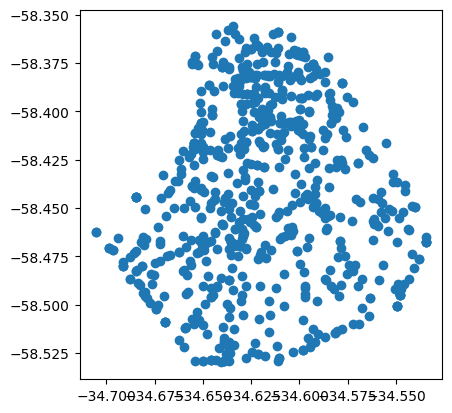

In [9]:
# ---> Creación de la columna 'localizador' para almacenar las coordenadas: 'latitud' (POSY), 'longitud' (POSX)
df_vh['localizador'] = df_vh.apply(lambda row: f"{row['POSY']}, {row['POSX']}", axis=1)

# ---> Conversión de coordenadas a elementos tipo Point
df_vh['geometry'] = df_vh['localizador'].apply(lambda x: Point(map(float, x.split(', '))))
df_vhgeolocalizador = gpd.GeoDataFrame(df_vh, geometry='geometry')
df_vhgeolocalizador.plot()
plt.show()

In [25]:
# ---> Cálcula del promedio  de 'POSY' y 'POSX' para localizar geográficamente el mapa
POSY_c = df_vh['POSY'].mean()
POSX_c = df_vh['POSX'].mean()


m = folium.Map(location=[POSY_c, POSX_c], zoom_start=11.5)        # ---> Generación del mapa

# ---> Iteración sobre el DataFrame para definir coordenadas válidas
count = 0
for index, row in df_vh.iterrows():
    coordinates = row['localizador']  
    if pd.notnull(coordinates):
        lat, lon = coordinates.split(', ')
        try:
            lat, lon = float(lat), float(lon)
            folium.Marker(location=[lat, lon]).add_to(m)
        except ValueError:
            count += 1                                          # ---> Conteo del número de coordenadas geoespaciales inválidas
               
print("El número de coordenadas geoespaciales inválidas es --->", count)         
m


El número de coordenadas geoespaciales inválidas es ---> 13


## 2. Filtración para uso de variables de interés

`Las variables de interés son agrupadas de acuerdo a su potencial oferta de información:`
* a. De acuerdo a su Frecuencia. Ej : fatalidades por unidad de tiempo.
* b. De acuerdo a su carácter Demográfico. Ej: fatalidades en función de género y/o edad.
* c. De acuerdo a su localización. Ej: fatalidades en función del lugar de ocurrencia.
* d. De acuerdo a su Modo. Ej: fatalidades en función del medio de transporte involucrado.


In [11]:
# ---> Creación de un DataFrame que contenga las columnas de interés, de acuerdo a los criterios previamente señalados
columnas_interes = ['EDAD_VICTIMA', 'FECHA_AA', 'FECHA_DD', 'FECHA_DECESO', 'FECHA_MM', 'ROL_VICTIMA',
                    'SEXO_VICTIMA', 'VH_VICTIMA', 'COMUNA', 'HH', 'LUGAR_HECHO', 'POSX', 'POSY', 'TIPO_CALLE', 'VH_ACUSADO']
df_vhf = df_vh.loc[:, columnas_interes]
df_vhf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   EDAD_VICTIMA  717 non-null    object 
 1   FECHA_AA      717 non-null    int64  
 2   FECHA_DD      717 non-null    int64  
 3   FECHA_DECESO  717 non-null    object 
 4   FECHA_MM      717 non-null    int64  
 5   ROL_VICTIMA   717 non-null    object 
 6   SEXO_VICTIMA  717 non-null    object 
 7   VH_VICTIMA    717 non-null    object 
 8   COMUNA        717 non-null    int64  
 9   HH            717 non-null    object 
 10  LUGAR_HECHO   717 non-null    object 
 11  POSX          704 non-null    float64
 12  POSY          704 non-null    float64
 13  TIPO_CALLE    717 non-null    object 
 14  VH_ACUSADO    717 non-null    object 
dtypes: float64(2), int64(4), object(9)
memory usage: 84.2+ KB


In [12]:
# ---> Reemplazar valores 'SD' y 'Sin Dato' por '0' en columna 'EDAD_VICTIMA' 
df_vhf['EDAD_VICTIMA'] = df_vhf['EDAD_VICTIMA'].replace('SD', '0')
df_vhf['HH'] = df_vhf['HH'].replace('SIN DATO', '0')

# ---> Conversión de columnas 'EDAD_VICTIMA' y 'HH' de tipo str a int
df_vhf['EDAD_VICTIMA'] = df_vhf['EDAD_VICTIMA'].astype('int64')
df_vhf['HH'] = df_vhf['HH'].astype('int64')

## 3. Tratamiento de Variables de interés

### 3.1 Análisis de valores Nulos o Pérdidos

In [13]:
df_vhf.duplicated().sum()                        # ---> Número de filas duplicadas

0

In [14]:
print(df_vhf.isna().sum())                      # ---> Número de campos Nulos

EDAD_VICTIMA     0
FECHA_AA         0
FECHA_DD         0
FECHA_DECESO     0
FECHA_MM         0
ROL_VICTIMA      0
SEXO_VICTIMA     0
VH_VICTIMA       0
COMUNA           0
HH               0
LUGAR_HECHO      0
POSX            13
POSY            13
TIPO_CALLE       0
VH_ACUSADO       0
dtype: int64


In [15]:
# ---> Conversión de valores nulos al número cero '0' en columnas 'POSY' y 'POSX'
df_vhf['POSY'] = df_vhf['POSY'].fillna(0)
df_vhf['POSX'] = df_vhf['POSX'].fillna(0)
df_vhf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   EDAD_VICTIMA  717 non-null    int64  
 1   FECHA_AA      717 non-null    int64  
 2   FECHA_DD      717 non-null    int64  
 3   FECHA_DECESO  717 non-null    object 
 4   FECHA_MM      717 non-null    int64  
 5   ROL_VICTIMA   717 non-null    object 
 6   SEXO_VICTIMA  717 non-null    object 
 7   VH_VICTIMA    717 non-null    object 
 8   COMUNA        717 non-null    int64  
 9   HH            717 non-null    int64  
 10  LUGAR_HECHO   717 non-null    object 
 11  POSX          717 non-null    float64
 12  POSY          717 non-null    float64
 13  TIPO_CALLE    717 non-null    object 
 14  VH_ACUSADO    717 non-null    object 
dtypes: float64(2), int64(6), object(7)
memory usage: 84.2+ KB


### 3.2 Análisis de Outliers

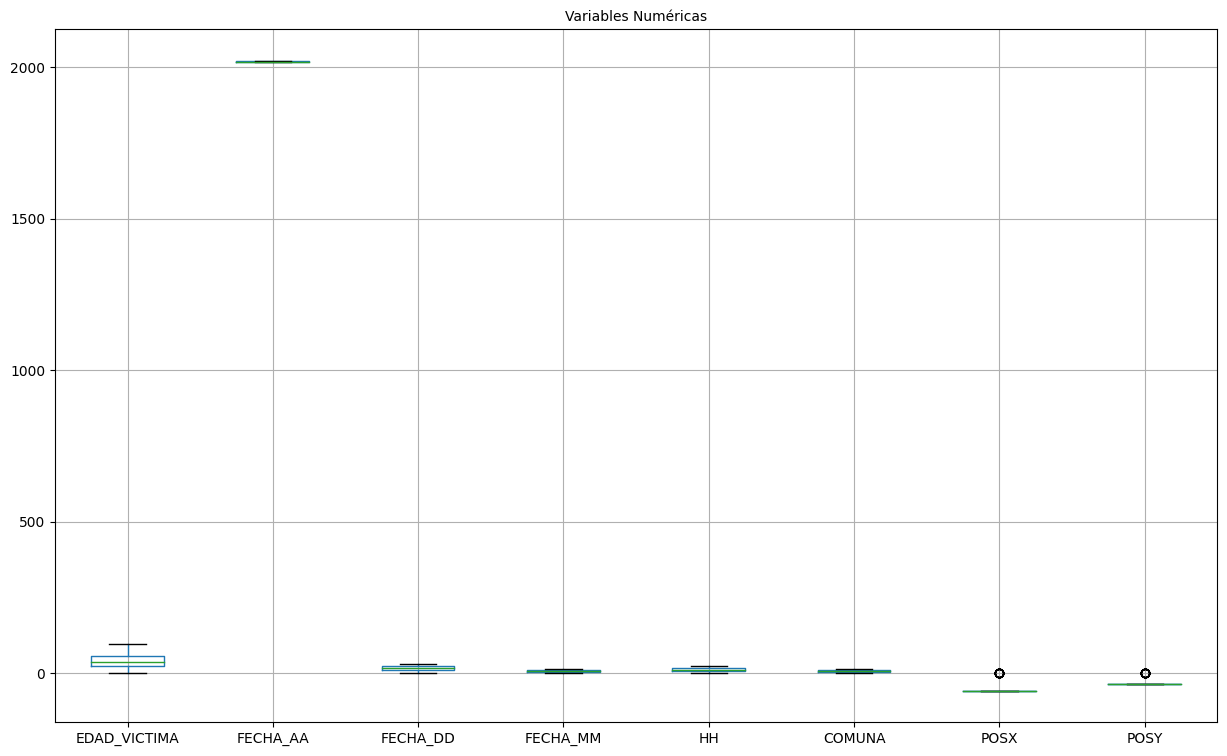

In [16]:
num_cols = ['EDAD_VICTIMA', 'FECHA_AA', 'FECHA_DD', 'FECHA_MM', 'HH', 'COMUNA', 'POSX', 'POSY']

plt.figure(figsize=(15,9))
df_vhf[num_cols].boxplot()
plt.title("Variables Numéricas", fontsize=10)
plt.show()

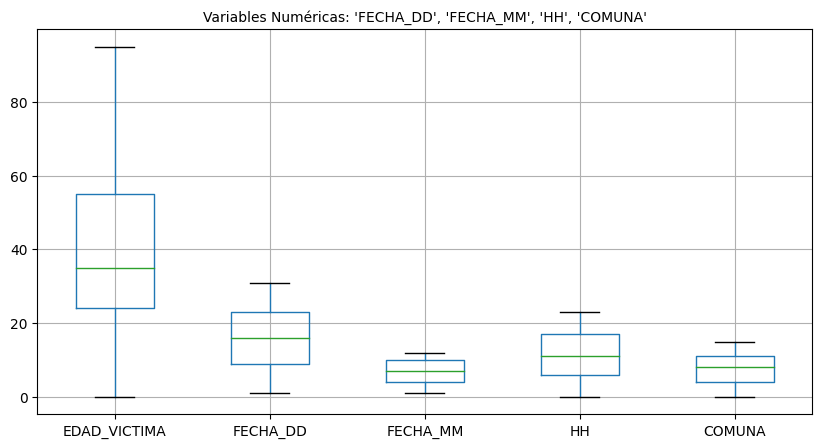

In [17]:
num_cols = ['EDAD_VICTIMA', 'FECHA_DD', 'FECHA_MM', 'HH', 'COMUNA']

plt.figure(figsize=(10,5))
df_vhf[num_cols].boxplot()
plt.title("Variables Numéricas: 'FECHA_DD', 'FECHA_MM', 'HH', 'COMUNA'", fontsize=10)
plt.show()

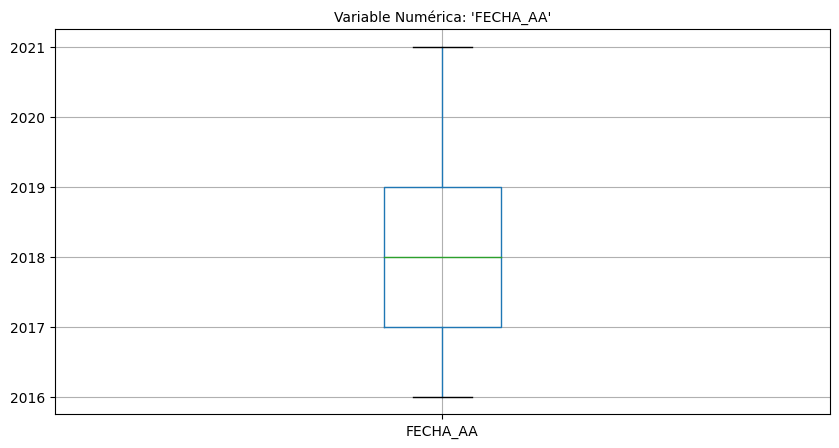

In [18]:
num_cols = ['FECHA_AA']

plt.figure(figsize=(10,5))
df_vhf[num_cols].boxplot()
plt.title("Variable Numérica: 'FECHA_AA'", fontsize=10)
plt.show()

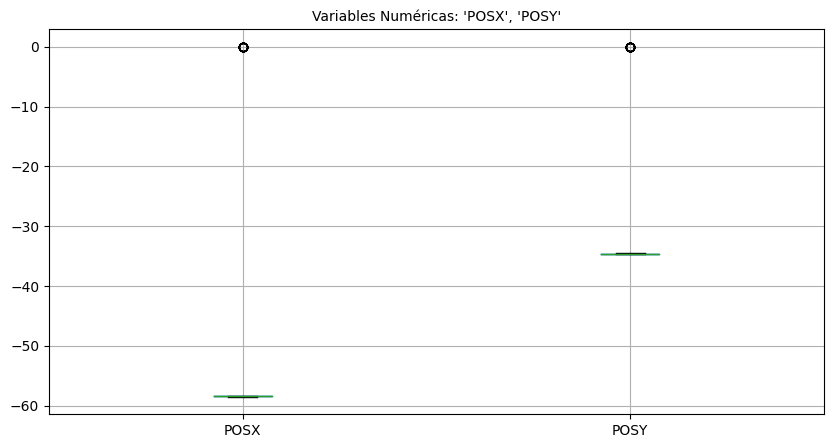

In [19]:
num_cols = ['POSX', 'POSY']

plt.figure(figsize=(10,5))
df_vhf[num_cols].boxplot()
plt.title("Variables Numéricas: 'POSX', 'POSY'", fontsize=10)
plt.show()

### 3.3 Visualización de las Variables Categóricas

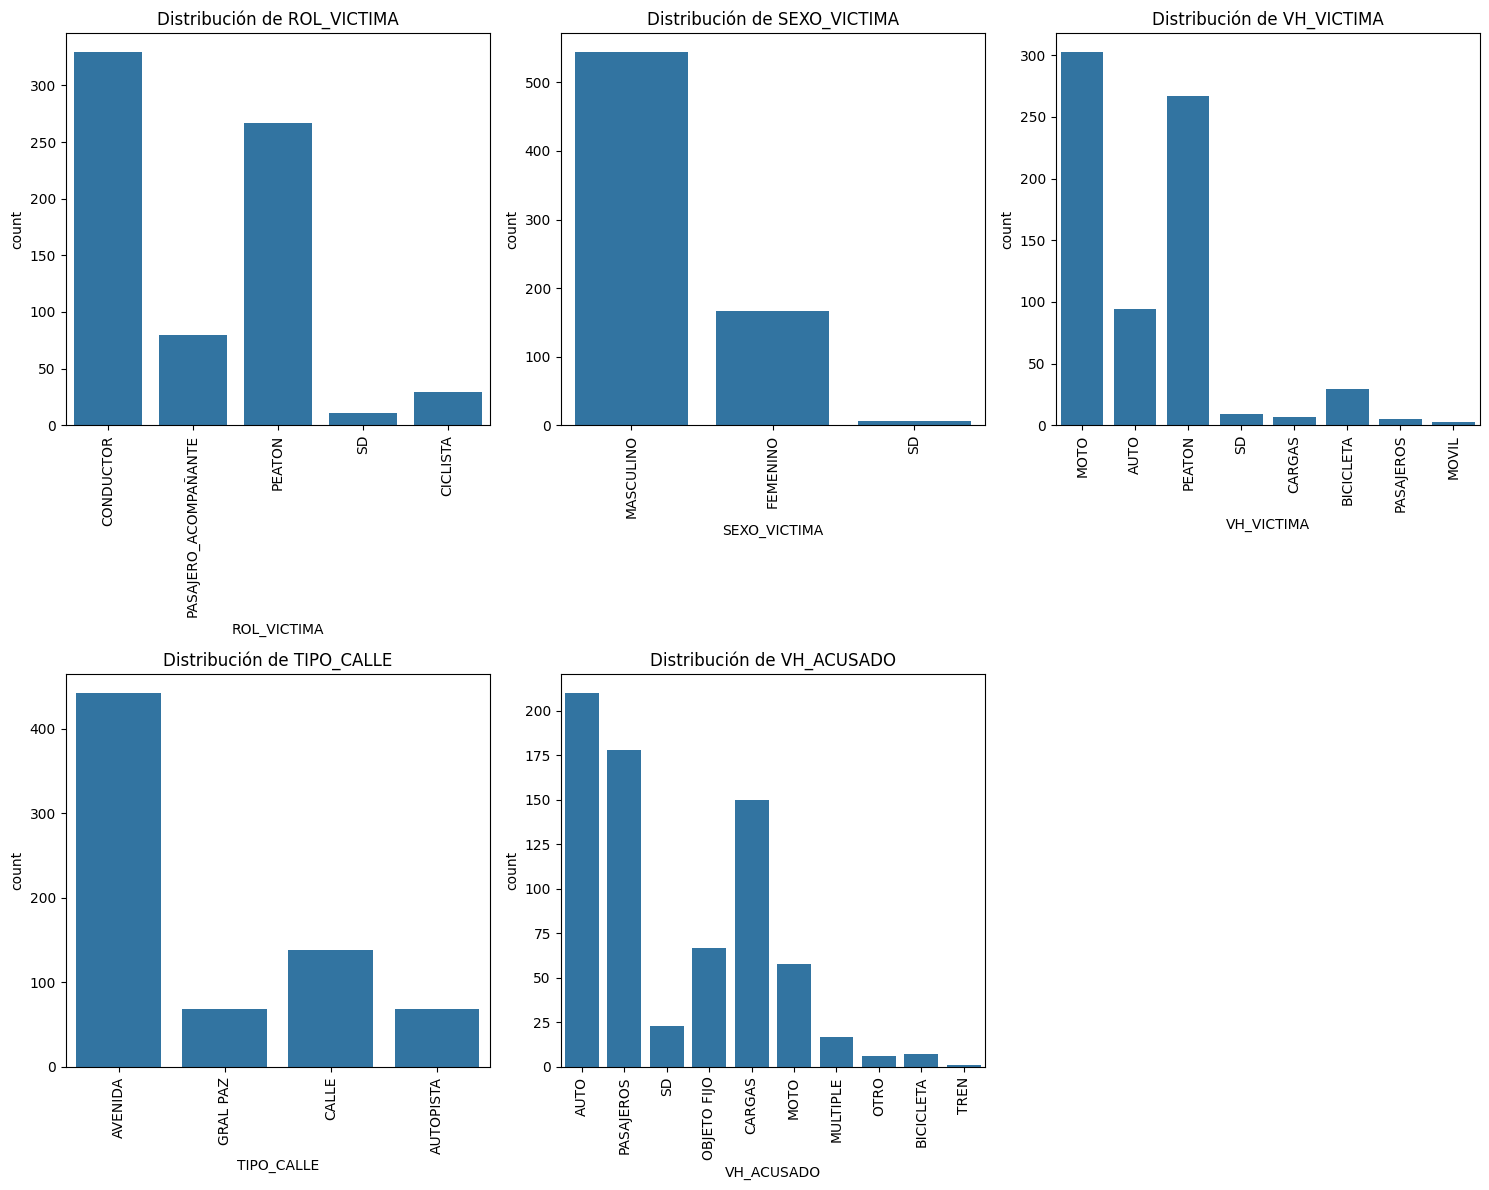

In [20]:
categoricas = ['ROL_VICTIMA','SEXO_VICTIMA', 'VH_VICTIMA', 'TIPO_CALLE', 'VH_ACUSADO']

plt.figure(figsize=(15, 12))


for i, columna in enumerate(categoricas, 1):        # ---> Generación de subplots para cada columna categórica
    plt.subplot(2, 3, i)  
    sns.countplot(data=df_vhf, x=columna)
    plt.title(f'Distribución de {columna}')
    plt.xticks(rotation=90)                         # ---> Rotación etiquetas sobre eje x para lograr legibilidad

plt.tight_layout()

plt.show()

### 3.4 Visualización Histográfica

* Primero es necesario preparar las variables categóricas para ser analizadas en una matriz (uso de 'LabelEncoder'), junto con el resto de las variables numéricas del Dataframe

In [21]:
df_vhf_cor = df_vhf

le = LabelEncoder()     # ---> Codificación de variables categóricas
df_vhf_cor['FECHA_DECESO'] = le.fit_transform(df_vhf['FECHA_DECESO'])
df_vhf_cor['ROL_VICTIMA'] = le.fit_transform(df_vhf['ROL_VICTIMA'])
df_vhf_cor['SEXO_VICTIMA'] = le.fit_transform(df_vhf['SEXO_VICTIMA'])
df_vhf_cor['VH_VICTIMA'] = le.fit_transform(df_vhf['VH_VICTIMA'])
df_vhf_cor['LUGAR_HECHO'] = le.fit_transform(df_vhf['LUGAR_HECHO'])
df_vhf_cor['TIPO_CALLE'] = le.fit_transform(df_vhf['TIPO_CALLE'])
df_vhf_cor['VH_ACUSADO'] = le.fit_transform(df_vhf['VH_ACUSADO'])

array([[<Axes: title={'center': 'EDAD_VICTIMA'}>,
        <Axes: title={'center': 'FECHA_AA'}>,
        <Axes: title={'center': 'FECHA_DD'}>,
        <Axes: title={'center': 'FECHA_DECESO'}>],
       [<Axes: title={'center': 'FECHA_MM'}>,
        <Axes: title={'center': 'ROL_VICTIMA'}>,
        <Axes: title={'center': 'SEXO_VICTIMA'}>,
        <Axes: title={'center': 'VH_VICTIMA'}>],
       [<Axes: title={'center': 'COMUNA'}>,
        <Axes: title={'center': 'HH'}>,
        <Axes: title={'center': 'LUGAR_HECHO'}>,
        <Axes: title={'center': 'POSX'}>],
       [<Axes: title={'center': 'POSY'}>,
        <Axes: title={'center': 'TIPO_CALLE'}>,
        <Axes: title={'center': 'VH_ACUSADO'}>, <Axes: >]], dtype=object)

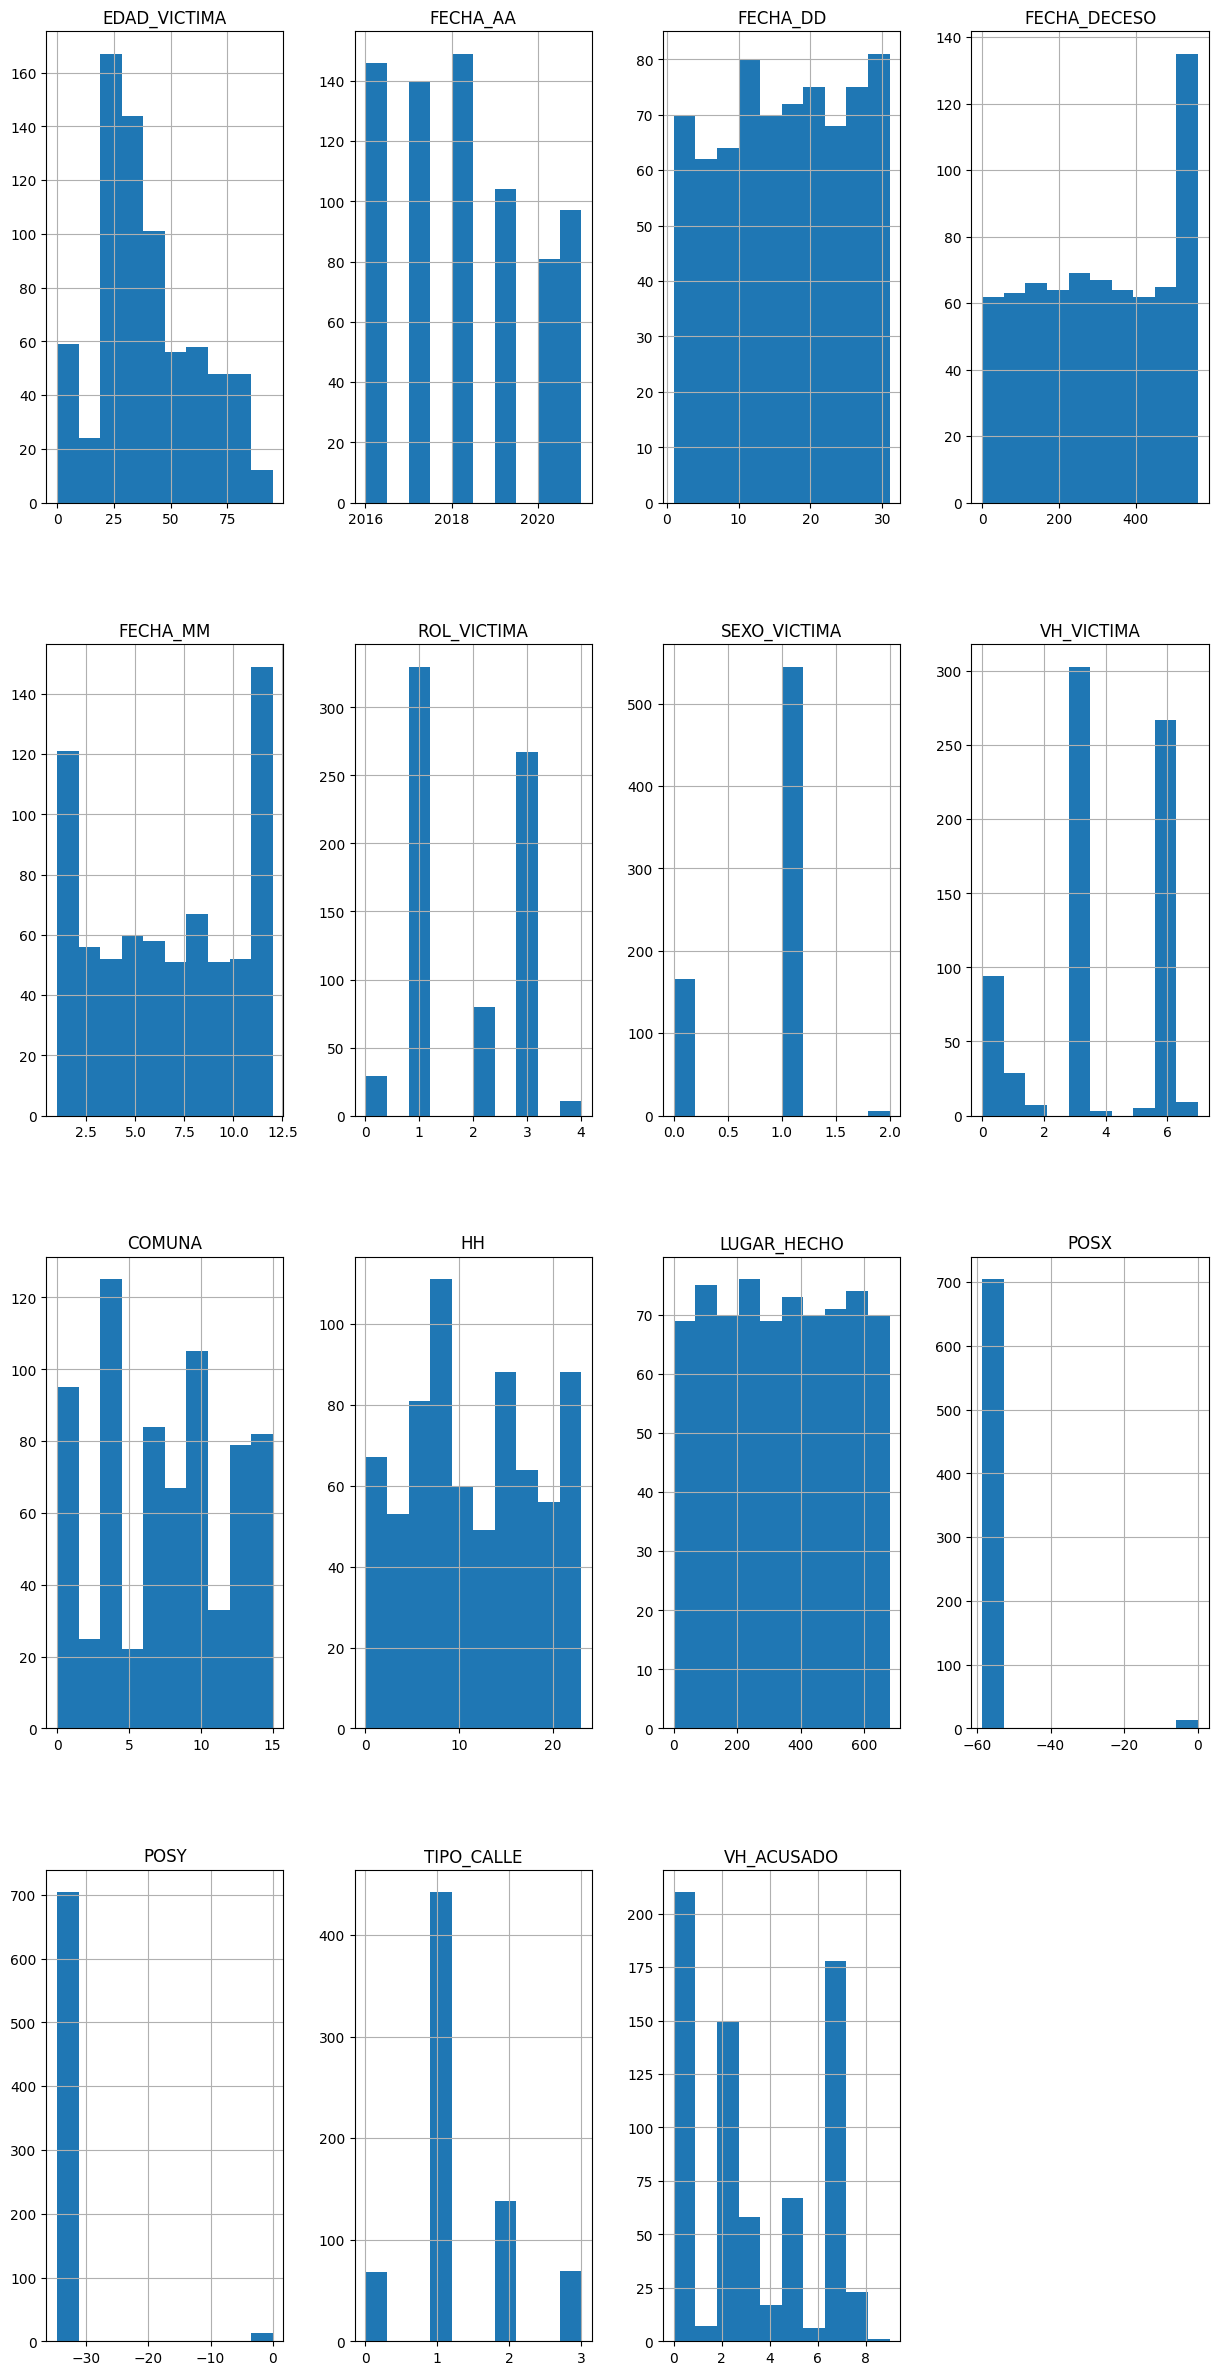

In [22]:
df_vhf_cor.hist(figsize=(15,30))

In [23]:
df_vhf_cor.corr()

,EDAD_VICTIMA,FECHA_AA,FECHA_DD,FECHA_DECESO,FECHA_MM,ROL_VICTIMA,SEXO_VICTIMA,VH_VICTIMA,COMUNA,HH,LUGAR_HECHO,POSX,POSY,TIPO_CALLE,VH_ACUSADO
EDAD_VICTIMA,1.000000,0.097067,-0.009606,-0.070790,0.031134,0.291823,-0.235600,0.259854,-0.047759,0.193356,0.067874,-0.121220,-0.121220,0.023281,0.045649
FECHA_AA,0.097067,1.000000,-0.042225,-0.172932,-0.039499,-0.057152,-0.036565,-0.011753,0.017353,-0.045338,0.283156,-0.051621,-0.051239,-0.027487,-0.100655
FECHA_DD,-0.009606,-0.042225,1.000000,0.068435,-0.026260,0.000653,0.028663,-0.020995,-0.000071,-0.018529,-0.000151,0.010069,0.009976,0.029997,0.014354
FECHA_DECESO,-0.070790,-0.172932,0.068435,1.000000,0.055021,-0.018301,0.054684,-0.011173,0.055360,0.016191,-0.076074,-0.020539,-0.020346,-0.017591,0.029567
FECHA_MM,0.031134,-0.039499,-0.026260,0.055021,1.000000,-0.007205,-0.040975,-0.023437,0.058184,0.023177,-0.065594,-0.003270,-0.002800,-0.002193,0.058127
ROL_VICTIMA,0.291823,-0.057152,0.000653,-0.018301,-0.007205,1.000000,-0.270477,0.810590,-0.063248,0.178010,0.054341,0.018963,0.018674,-0.016576,0.109137
SEXO_VICTIMA,-0.235600,-0.036565,0.028663,0.054684,-0.040975,-0.270477,1.000000,-0.204489,-0.058434,-0.100130,-0.069534,0.165466,0.165050,-0.048323,0.024075
VH_VICTIMA,0.259854,-0.011753,-0.020995,-0.011173,-0.023437,0.810590,-0.204489,1.000000,-0.056585,0.243863,0.107417,0.005154,0.005129,-0.049107,0.099301
COMUNA,-0.047759,0.017353,-0.000071,0.055360,0.058184,-0.063248,-0.058434,-0.056585,1.000000,-0.040083,0.024569,0.006508,0.013013,0.119265,-0.083065
HH,0.193356,-0.045338,-0.018529,0.016191,0.023177,0.178010,-0.100130,0.243863,-0.040083,1.000000,-0.006574,0.005011,0.004964,-0.047465,0.032679


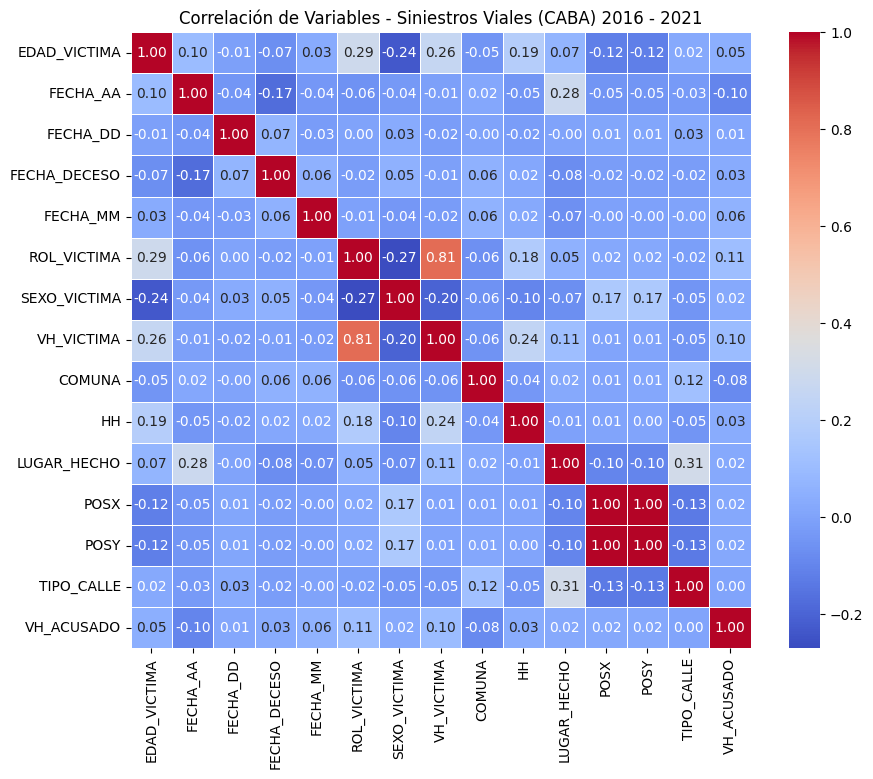

In [24]:
# ---> Asignación de todas las variables de interés para llevar a cabo el análisis correlacional
all_variables = df_vhf_cor[['EDAD_VICTIMA', 'FECHA_AA', 'FECHA_DD', 'FECHA_DECESO', 'FECHA_MM', 'ROL_VICTIMA',
                           'SEXO_VICTIMA', 'VH_VICTIMA', 'COMUNA', 'HH', 'LUGAR_HECHO', 'POSX', 'POSY', 'TIPO_CALLE', 'VH_ACUSADO']]

matriz_correlacion = all_variables.corr()

# ---> Creación gráfica para visualizar en colores la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlación de Variables - Siniestros Viales (CABA) 2016 - 2021')
plt.show()


## 4. Conclusiones

* **Sobre información inválida o pérdida (missing):**
Únicamente fueron encontrados errores simples en datos aislados de las variables de interés: 'HORA', 'HH', 'POSX' y 'POSY'. Todos superados sin incidencia alguna en el análisis EDA.

* **Sobre información de los datos atípicos (Outliers):**  
En las columnas; 'POSX' y 'POSY' fueron evidenciados datos atípicos, no obstante su existencia es explicable razonablemente. Para el tema de las localizaciones geoespaciales (POSX, POSY), los datos atípicos hacen relación al valor cero '0' que les fue asignado a aquellos campos en ausencia de algún valor en los datos del dataset original, representando apenas un 1.81% de la muestra para dichas variables.

* **Sobre la información de potenciales correlaciones entre las variables:**
Al respecto el ejercicio nos muestra evidencia de una fuerte relación, de '0.81' entre las variables; 'ROL_VICTIMA' y 'VH_VICTIMA', reflejando la importancia que tienen tanto el vehículo de movilización, como la posición que ocupa la víctima en dicho vehículo. Esas variables, a su vez parecen mostrar algunas correlaciones, aunque muy moderada, con las edades de las víctimas ('0.29' y '0.26' respectivamente). De igual forma, la variable 'FECHA_AA' (Año del siniestro) muestra una correlación de baja intensidad con la variable 'LUGAR_HECHO' ('0.28'), en tanto que la variable 'HH' (Hora del siniestro) tiene una relación moderada baja ('0.24') con el tipo de vehículo en el que se transporta la víctima siniestrada. Por último se evidencia una correlación baja, del '0.31' entre el lugar del siniestro (Dirección donde ocurrió el siniestro) y el tipo de vía de tránsito (Avenidas, Calles, Autopistas o Avenida General Paz).